In [1]:
import math, yaml, sys

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from IPython.display import display, HTML

import matplotlib.pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style('ticks')
style.use('ggplot')
%matplotlib inline

In [2]:
# First we need a schema file
schema = yaml.safe_load(open('schema.yaml', 'r').read())

# convert schema categorical values to string
for c in schema['columns']:
    coldata = schema['columns'][c]
    if 'categories' in coldata:
        coldata['categories'] = [ str(x) for x in coldata['categories'] ]

In [3]:
# Identify which columns are to be loaded as string
dtypes = {}
for c in schema['columns']:
    if schema['columns'][c]['type'] == 'CATEGORICAL':
        dtypes[c] = str

# load data
train = pd.read_csv('train.csv', dtype=dtypes)
test = pd.read_csv('test.csv', dtype=dtypes)

train0 = train.copy()

## Prep

In [4]:
target = schema['target']
labels = train[target]
features = set(train.columns) - set([target,schema['id']])
print features
train.drop([target],axis=1,inplace=True)

set(['3SsnPorch', 'MasVnrType', 'LotConfig', 'LandSlope', 'GarageQual', 'Exterior1st', 'GarageFinish', '2ndFlrSF', 'HalfBath', 'OverallQual', 'OverallCond', 'LotArea', 'Electrical', 'BsmtQual', 'HouseStyle', 'GrLivArea', 'YearRemodAdd', 'MasVnrArea', 'Foundation', '1stFlrSF', 'BsmtFullBath', 'BsmtCond', 'HeatingQC', 'LotFrontage', 'MiscVal', 'CentralAir', 'BsmtExposure', 'Utilities', 'KitchenAbvGr', 'WoodDeckSF', 'LotShape', 'BsmtHalfBath', 'TotalBsmtSF', 'Condition1', 'Condition2', 'TotRmsAbvGrd', 'MiscFeature', 'YrSold', 'PavedDrive', 'OpenPorchSF', 'LowQualFinSF', 'BsmtUnfSF', 'GarageYrBlt', 'BldgType', 'FullBath', 'SaleType', 'MSZoning', 'Exterior2nd', 'Heating', 'MSSubClass', 'GarageCars', 'YearBuilt', 'KitchenQual', 'BsmtFinType2', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageType', 'LandContour', 'PoolArea', 'Neighborhood', 'ScreenPorch', 'Fence', 'MoSold', 'SaleCondition', 'ExterQual', 'Functional', 'Alley', 'RoofStyle', 'Street', 'Fireplaces', 'GarageArea', 'ExterCond', 

In [5]:
all_data = pd.concat((train, test)).reset_index(drop=True)

## Check Sizing

In [6]:
print '# traning observations',train.shape[0]
print '# testing observations',test.shape[0]

print '# traning columns',train.shape[1]
print '# testing columns',test.shape[1]

if not train.shape[1] == train.shape[1]:
    print 'ERROR: inconsistent number of columns between train and test!'

# traning observations 1460
# testing observations 1459
# traning columns 80
# testing columns 80


## Check train+test missing data

Number of features with missing data: 34


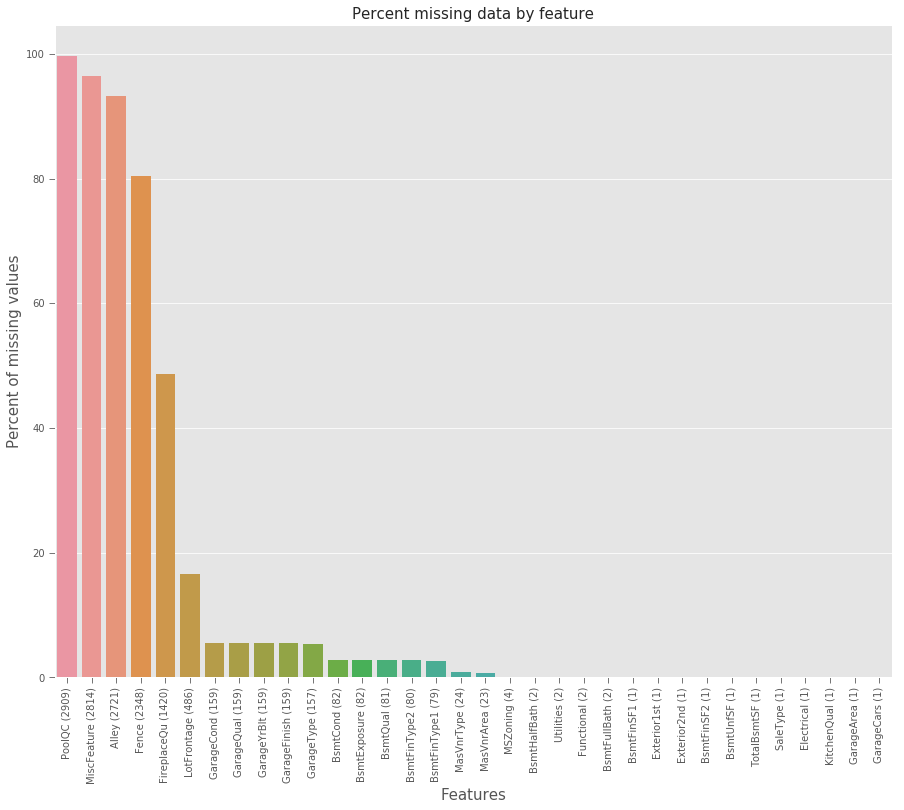

In [7]:
# Check missing data
all_data_na = all_data.isnull().sum(axis=0).sort_values(ascending=False)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)

nmissing = all_data_na.shape[0]
print 'Number of features with missing data:',nmissing

if nmissing > 0:
    all_data_na_pct = (all_data_na / all_data.shape[0]) * 100

    annotations = ["{} ({})".format(a, b) for a, b in zip(all_data_na.index, all_data_na.values)]

    f, ax = plt.subplots(figsize=(15, 12))
    sns.barplot(x=annotations, y=all_data_na_pct)

    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

## Check train+test mispelled categorical data

In [8]:
categorical_features = [c for c in features if schema['columns'][c]['type'] == 'CATEGORICAL' ]
#print 'categorical features:',categorical_features

for c in categorical_features:
    cats = schema['columns'][c]['categories']
    tmp = train[~train[c].isna()]
    tmp = tmp[~tmp[c].isin(cats)]

    if len(tmp) > 0:
        #print '/!\ Found unknown categorical values for column',c
        sumary = tmp.groupby(c).size().sort_values(ascending=False)
        display(HTML(sumary.to_frame().to_html()))
        print 'Valid categories',cats
        print '-------------------------------------------------------------------------------------------------------------------'

,0
BsmtExposure,
No,953


Valid categories ['NA', 'False', 'Mn', 'Av', 'Gd']
-------------------------------------------------------------------------------------------------------------------


,0
BldgType,
Duplex,52
Twnhs,43
2fmCon,31


Valid categories ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI']
-------------------------------------------------------------------------------------------------------------------


,0
Exterior2nd,
CmentBd,60
Wd Shng,38
Brk Cmn,7


Valid categories ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']
-------------------------------------------------------------------------------------------------------------------


,0
Neighborhood,
NAmes,225


Valid categories ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
-------------------------------------------------------------------------------------------------------------------


## Check train columns with unique value
This is only relevant if the missing data has already been fixed first.

In [9]:
for c in train.columns:
    if train[c].nunique() <= 1:
        print 'Column',c,'has only one value:',train[c].any()

## Check target variable

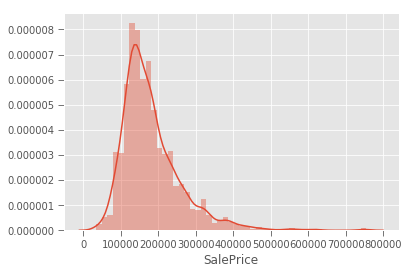

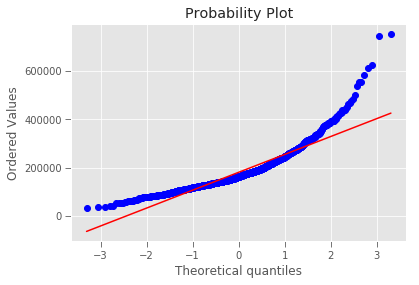

In [10]:
sns.distplot(labels)

fig = plt.figure()
res = stats.probplot(labels, plot=plt)
plt.show()

## Check linearity of train NUMERIC features

33 numeric features found


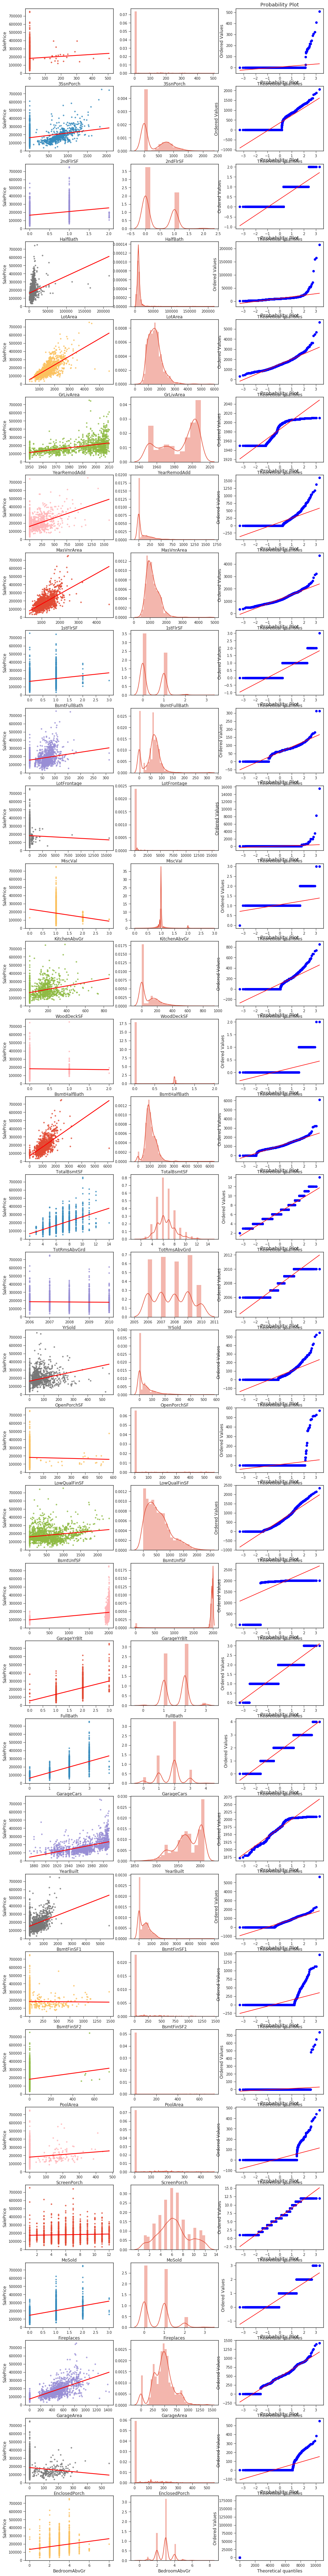

In [11]:
if True:
    numeric_features = [c for c in features if schema['columns'][c]['type'] == 'NUMERIC' and train[c].nunique() > 2 ]

    n_num_feat = len(numeric_features)
    print n_num_feat,'numeric features found'

    sns.set_style('ticks')
    fig, ax = plt.subplots(len(numeric_features),3,figsize=(15, n_num_feat*4))
    for i,c in enumerate(numeric_features):
        values = train[c].fillna(0)
        sns.regplot(x=values, y=labels, ax=ax[i,0], scatter_kws={"s": 10},
                    line_kws={'color':'red'}, order=1, ci=None, truncate=True)
        sns.distplot(values,ax=ax[i,1])
        res = stats.probplot(values, plot=ax[i,2])

## Check linearity and population of train CATEGORICAL features

46 categorical features found


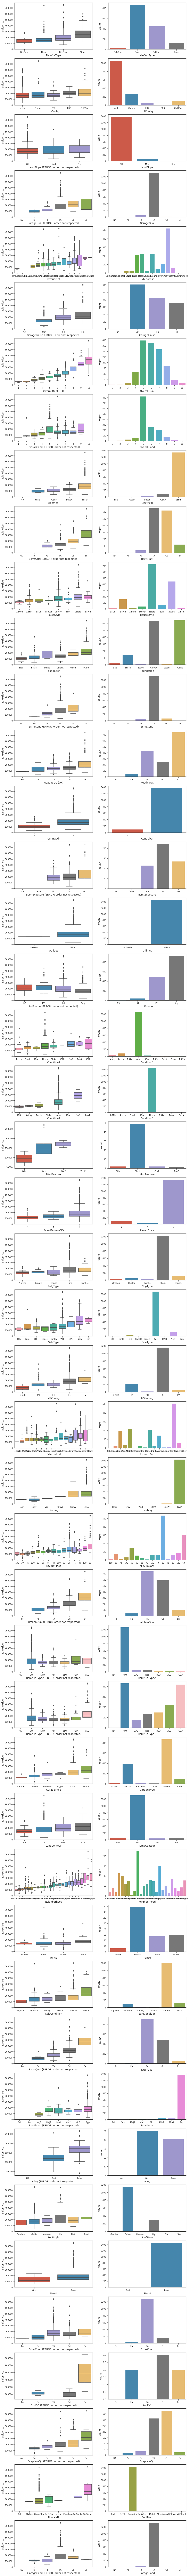

In [12]:
if True:
    categorical_features = [c for c in features if (schema['columns'][c]['type'] == 'CATEGORICAL' or schema['columns'][c]['type'] == 'BINARY') and train[c].nunique() > 1 ]
    n_cat_feat = len(categorical_features)
    print n_cat_feat,'categorical features found'

    sns.set_style('ticks')
    fig, axs = plt.subplots(len(categorical_features), 2, figsize=(15, n_cat_feat*5))

    for idx,c in enumerate(categorical_features):
        coldata = schema['columns'][c]
        categories = coldata['categories']
        meaningful_order = 'meaningful_order' in coldata and coldata['meaningful_order']

        sorted_by_mean = train0[target].groupby(train0[c]).median().sort_values()
        sorted_cats = [ str(x) for x in sorted_by_mean.index ]
        
        display_order = sorted_cats
        boxplot_xname = c

        if meaningful_order:
            # we expect the target to grow with the order
            if sorted_cats == categories:
                boxplot_xname = c+' (OK)'
            else:
                display_order = categories
                boxplot_xname = c+' (ERROR: order not respected)'

        data = pd.concat([labels, train[c]], axis=1)
        sns.boxplot(x=c, y=target, data=data,ax=axs[idx,0],order=display_order)
        axs[idx,0].set_xlabel(boxplot_xname)
        sns.countplot( x=train[c],ax=axs[idx,1], order=display_order)